<a href="https://colab.research.google.com/github/2SUBDA/Breakouts/blob/Week5/Week5SparkBasic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark import SparkContext

import collections
import pandas as pd


In [0]:
# CREATE ENVIRONMENT

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
# OBTAIN DATA - Housing

# os.listdir('./sample_data') #This will show the sample data in your colab instance

file_loc = './sample_data/california_housing_train.csv'

df_spark = spark.read.csv(file_loc, inferSchema=True, header=True)

In [6]:
# EXPLORE DATA

df_spark.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [7]:
# EXPLORE DATA

df_spark.show()


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|           73400.0|
|  -114.57|   33.57|              20.0|     1454.0|         326.0|     624.0|     262.0|        1.925|           65500.0|
|  -114.58|   33.63|    

In [8]:
# EXPLORE DATA - 

pdf = df_spark.toPandas()
pdfplot = pdf[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_house_value']]
pdfplot.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_house_value
0,15.0,5612.0,1283.0,1015.0,472.0,66900.0
1,19.0,7650.0,1901.0,1129.0,463.0,80100.0
2,17.0,720.0,174.0,333.0,117.0,85700.0
3,14.0,1501.0,337.0,515.0,226.0,73400.0
4,20.0,1454.0,326.0,624.0,262.0,65500.0


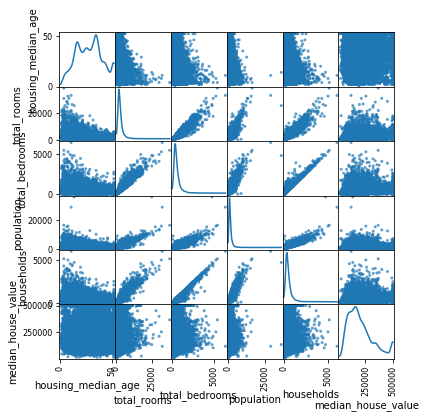

In [9]:
from pandas.plotting import scatter_matrix
stuff = scatter_matrix(pdfplot, alpha=0.7, figsize=(6, 6), diagonal='kde')

In [0]:
# ADD MODULES FOR MODELING

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [11]:
# SCRUB DATA

#Input all the features in one vector column
assembler = VectorAssembler(inputCols=['housing_median_age', 'total_rooms', 'total_bedrooms'], outputCol = 'Attributes')
output = assembler.transform(df_spark)
#Input vs Output
finalized_data = output.select("Attributes","median_house_value")
finalized_data.show()


+--------------------+------------------+
|          Attributes|median_house_value|
+--------------------+------------------+
|[15.0,5612.0,1283.0]|           66900.0|
|[19.0,7650.0,1901.0]|           80100.0|
|  [17.0,720.0,174.0]|           85700.0|
| [14.0,1501.0,337.0]|           73400.0|
| [20.0,1454.0,326.0]|           65500.0|
| [29.0,1387.0,236.0]|           74000.0|
| [25.0,2907.0,680.0]|           82400.0|
|  [41.0,812.0,168.0]|           48500.0|
|[34.0,4789.0,1175.0]|           58400.0|
| [46.0,1497.0,309.0]|           48100.0|
| [16.0,3741.0,801.0]|           86500.0|
| [21.0,1988.0,483.0]|           62000.0|
| [48.0,1291.0,248.0]|           48600.0|
| [31.0,2478.0,464.0]|           70400.0|
| [15.0,1448.0,378.0]|           45000.0|
| [17.0,2556.0,587.0]|           69100.0|
| [28.0,1678.0,322.0]|           94900.0|
|    [21.0,44.0,33.0]|           25000.0|
| [17.0,1388.0,386.0]|           44000.0|
|    [17.0,97.0,24.0]|           27500.0|
+--------------------+------------

In [0]:
# SCRUB THE DATA - Training & Test
train_data,test_data = finalized_data.randomSplit([0.8,0.2])


In [13]:
# MODEL - Build a Linear Regression Model

# SPECIFY THE MODEL
regressor = LinearRegression(featuresCol = 'Attributes', labelCol = 'median_house_value')

# FIT THE MODEL
regressor = regressor.fit(train_data)

# PREDICT AGAINST TEST SET
pred = regressor.evaluate(test_data)

# SHOW MODEL PREDICTIONS
pred.predictions.show()

+-------------------+------------------+------------------+
|         Attributes|median_house_value|        prediction|
+-------------------+------------------+------------------+
|  [2.0,838.0,295.0]|          237500.0|130028.32377221837|
| [2.0,1658.0,290.0]|          136700.0| 161923.9088744437|
| [2.0,4055.0,735.0]|           96500.0| 184737.6044823436|
| [2.0,4198.0,805.0]|          122100.0|179440.85150446132|
| [2.0,6718.0,858.0]|          305200.0|266986.38364939287|
| [3.0,1167.0,306.0]|          217500.0|142553.90254267905|
| [3.0,1170.0,148.0]|          500001.0|166876.62106958107|
| [3.0,1565.0,464.0]|          231300.0|133454.26040051098|
| [3.0,2443.0,637.0]|          183300.0| 140278.4479170476|
|[3.0,4778.0,1047.0]|          271400.0|166101.16646190608|
| [3.0,5284.0,920.0]|          126500.0|204769.33157323633|
|[3.0,6577.0,1056.0]|          251800.0|233017.23088389434|
|[3.0,7985.0,1257.0]|          158300.0|255671.52148534343|
|[3.0,9217.0,1522.0]|          189100.0|

In [14]:
# MODEL - Evaluate

eval = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
rmse = eval.evaluate(pred.predictions)
print("RMSE: %.3f" % rmse)

mse = eval.evaluate(pred.predictions, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

mae = eval.evaluate(pred.predictions, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

r2 = eval.evaluate(pred.predictions, {eval.metricName: "r2"})
print("r2: %.3f" %r2)


RMSE: 111371.444
MSE: 12403598624.100
MAE: 87402.980
r2: 0.099
